# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'


"""
Simple program to use a convolutional neural network to obtain a predictive coder,
using explicit inputs to layers, to enable skip layers.
According to: https://keras.io/getting-started/functional-api-guide/
With Pytorch
For instance according to WCLMS or prediction Boosting
Gerald Schuller, November 2018.
"""

In [1]:
# Importing necessary modules.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt         
import sys
import pickle
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from sklearn.preprocessing import normalize

In [2]:
# Choosing one file from our dataset, that we already have as a numpy array.

t = np.load('/Users/DELL/Updated_binder_enviro/all-samples/banjo/banjo_A3_very-long_forte_normal.npy')
sr = 44100    
print(t)
print(type(t))

[0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'>


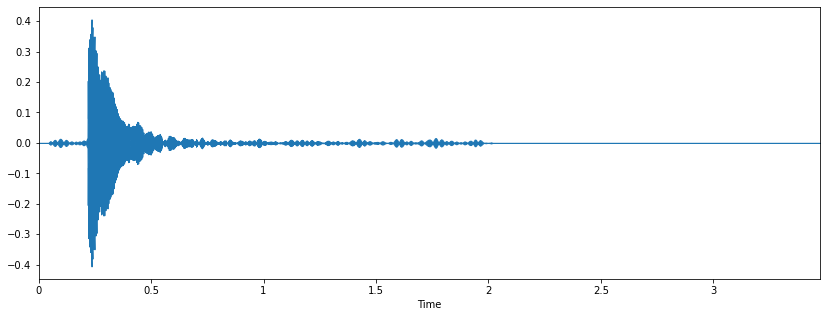

In [3]:
# Plotting the original audio file

plt.figure(figsize=(14, 5))     
librosa.display.waveplot(t, sr=sr);

In [4]:
# Playing the original audio file
import IPython.display as ipd  #play back the original audio file
ipd.Audio(data=t,rate=sr,autoplay=True)      #understood that we are playing back the original file here


In [5]:
# Pre-processing of the audio file if needed.


numpt = t/(np.abs(t).max())   # Here we are doing Peak- normalization of the audio file
print(type(numpt))

audio=torch.from_numpy(numpt)   # Converting the normalized audio file from numpy to Tensor
print(type(audio))

audiosh=audio[:100000]    # Making the audio a bit short for faster processing           
X = audiosh[:99999]    # test data
Y =audiosh[1:100000]   # target data
print(X.shape)    
print(Y.shape)

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
torch.Size([99999])
torch.Size([99999])


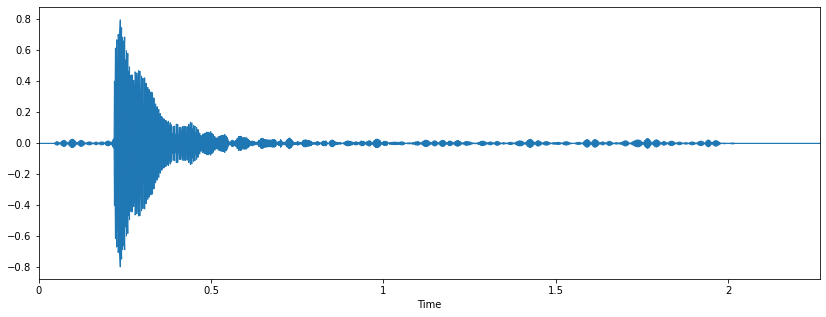

In [6]:
# Play back and display of the shortened audio file

%matplotlib inline

plt.figure(figsize=(14, 5))      
librosa.display.waveplot(X.numpy(), sr=sr)
ipd.Audio(data=X.numpy(),rate=sr,autoplay=True)



In [7]:
L=12 #filter length       
dilation=1 #Dilation: upsampling the filter impulse response, new filter length: (L-1)*dilation+1



In [8]:
 #Writing a function to convert the test and target data to be the kind of input Conv1d expects

def format_vector2pytorch(vector):
    
    #Function to convert a vector, like a mono audio signal, into a 3-d Tensor X that Keras expects
    #Tensor X with shape (batch, signal):
    #https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761
    
    X = np.expand_dims(vector, axis=0)  #add batch dimension (here only 1 batch)
    X = np.expand_dims(X, axis=0)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)     
    return X


In [1]:
# Converting the input to the type of inputs that a Convolutional layer expects by calling the function

X=format_vector2pytorch(audiosh[:-((L-1)*dilation+1)])      #remove last samples 
Y=format_vector2pytorch(audiosh[1:]) #r

print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)   

  

NameError: name 'format_vector2pytorch' is not defined

In [12]:
# Defining of the PyTorch model

class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # defining network layers
        self.layer1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=L, stride=1, dilation=dilation, padding=dilation*(L-1), bias=False)
        
        
    def forward(self, x):
        # define forward pass          
        x = self.layer1(x)
        return x
print("Generate Model:")
model = MyNetwork()
print(model)


Generate Model:
MyNetwork(
  (layer1): Conv1d(1, 1, kernel_size=(12,), stride=(1,), padding=(11,), bias=False)
)


In [16]:
# Definition of the loss function and the optimizer

n_epochs = 1000
learning_rate = 1e-4
print("Def. loss function:")   

loss_fn = nn.MSELoss()       # Defining loss function as Mean Square Error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    

Def. loss function:


In [17]:
# Training of the model

for epoch in range(1000):
    Ypred=model(X)
    loss=loss_fn(Ypred, Y)    # Calculation of Mean Square Error
    if epoch%100==0:        
        print(epoch, loss.item())  
        optimizer.zero_grad()     # Setting the gradient to zero for every cycle
        loss.backward()         # Calculation of gradient
        optimizer.step()        # Using optimizer.step to update the values


0 0.004174979869276285
100 0.004170200787484646
200 0.004165430553257465
300 0.00416067149490118
400 0.004155919421464205
500 0.004151178989559412
600 0.004146446939557791
700 0.004141726065427065
800 0.0041370149701833725
900 0.0041323136538267136


In [18]:
# Predictions after the model is trained

predictions=model(X)   
print(predictions)
print(predictions.shape)  # Checking its shape to see the dimensions

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.1090e-05,
           1.0889e-05, -7.5877e-06]]], grad_fn=<SqueezeBackward1>)
torch.Size([1, 1, 99999])


In [24]:
# Computation of the prediction errors

#mean squared predicton error:

err= sum((predictions[0,0,:]-Y[0,0,:])**2)/max(Y.shape)
print("mean squared prediction error=", err)

print(err.shape)



mean squared prediction error= tensor(0.0041, grad_fn=<DivBackward0>)
torch.Size([])


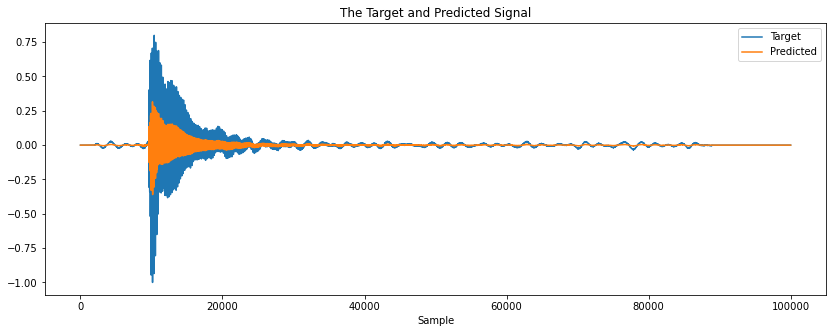

In [30]:
# Plots of the Predictions and the target 

plt.figure(figsize=(14, 5))    
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:])
plt.legend(('Target','Predicted'))
plt.title('The Target and Predicted Signal')
plt.xlabel('Sample');


In [31]:
# Saving the model

torch.save({'epoch': epoch,        
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "linpredweights.torch")